### Convert original .docx file (Auswahl 3 - mit erwünschten Löschungen und ohne Hervorgebungen und ohne Kontaktdaten) into .csv file 

In [1]:
import pandas as pd

csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/innerspeech_reflection_reports.csv'
df = pd.read_csv(csv_path)
#keep only the reflection_answer column
df

,reflection_answer
0,頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り...
1,他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラ...
2,頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字...
3,自動思考というものなのか、直近で起きた失敗などを批判する考えが勝手に浮かんできたりすることが...
4,食べたいもの、欲しいものなどは、自分がそれを食べている、或いは使っているところを想像して決め...
...,...
726,活字を読む時、内言を再生しないとほとんど意味として解されない感覚が通常かと思っていたが、以前...
727,視覚の内言はどの程度鮮明なイメージとして認識ができるか。私の場合はイメージは目で見るようなイ...
728,ことばや概念を思い出すとき、空中に指先で矩形を切る（想像をする）癖があり、ゲームなどのローデ...
729,フリック入力の感覚など、身体動作の内言？もある。


### Sample translate .csv file multilangual into English (using Gemini API)

In [ ]:




import pandas as pd
import google.generativeai as genai
from google.api_core import exceptions
import os
from dotenv import load_dotenv
from tqdm import tqdm
import time
import json
import numpy as np
import random

# --- SETUP AND CONFIGURATION ---

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
if not api_key:
    raise ValueError("API key not found. Please set the GOOGLE_API_KEY in your .env file.")
genai.configure(api_key=api_key)
model = genai.GenerativeModel('gemini-1.5-flash')

try:
    csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/innerspeech_reflection_reports.csv'
    df = pd.read_csv(csv_path)
    print(f"Successfully loaded {len(df)} rows to be translated from {csv_path}")
except FileNotFoundError:
    print(f"Error: The file could not be found at {csv_path}")
    df = pd.DataFrame({'reflection_answer': []}) # Create empty df if file not found

# --- BATCH TRANSLATION FUNCTION WITH EXPONENTIAL BACKOFF ---

def translate_batch_with_retry(texts: list[str], max_retries: int = 3) -> list[str]:
    """
    Translates a BATCH of texts, with automatic retries for rate limit errors.
    """
    numbered_texts = "\\n".join([f'"{i+1}": "{text}"' for i, text in enumerate(texts)])
    prompt = f"""Translate each of the following numbered Japanese texts to English.
Please return the result as a single, valid JSON object where keys are the numbers and values are the English translations.
The JSON object should have exactly {len(texts)} elements. Do not include any other explanatory text in your response.

TEXTS TO TRANSLATE:
{{
{numbered_texts}
}}
"""
    
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
            cleaned_response_text = response.text.strip().replace("```json", "").replace("```", "")
            translated_dict = json.loads(cleaned_response_text)
            translated_texts = [translated_dict.get(str(i+1), "Error: Missing translation") for i in range(len(texts))]

            if len(translated_texts) == len(texts):
                return translated_texts
            else:
                return ["Error: Mismatch in batch response"] * len(texts)

        except exceptions.ResourceExhausted as e:
            print(f"Rate limit exceeded. Waiting to retry... (Attempt {attempt + 1}/{max_retries})")
            retry_after = 15 * (2 ** attempt) + random.uniform(0, 1) # Exponential backoff with jitter
            print(f"Waiting for {retry_after:.2f} seconds.")
            time.sleep(retry_after)

        except Exception as e:
            print(f"An unexpected error occurred during a batch translation: {e}")
            return [f"Error: {e}"] * len(texts)
    
    print("All retries failed for this batch.")
    return ["Error: Max retries exceeded"] * len(texts)

# --- EXECUTE THE BATCHED TRANSLATION ---
if not df.empty:
    BATCH_SIZE = 20
    all_translations = []

    text_batches = np.array_split(df['reflection_answer'].dropna(), len(df) // BATCH_SIZE + 1)
    print(f"Split {len(df)} entries into {len(text_batches)} batches of up to {BATCH_SIZE} each.")

    for batch in tqdm(text_batches, desc="Translating Batches"):
        if batch.empty:
            continue
        translations = translate_batch_with_retry(batch.tolist())
        all_translations.extend(translations)
        time.sleep(1)

    df['reflection_answer_english'] = pd.Series(all_translations)
    
    # --- REVIEW AND SAVE RESULTS ---
    print("\\n--- Translation Results (First 5 Rows) ---")
    print(df[['reflection_answer', 'reflection_answer_english']].head())

    output_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/innerspeech_translated_batched.csv'
    df.to_csv(output_path, index=False)
    print(f"\\nTranslated data saved to {output_path}")
else:
    print("DataFrame is empty, skipping translation.")

/Users/rbeaute/Projects/MOSAIC/.mosavenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Successfully loaded 731 rows to be translated from /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/innerspeech_reflection_reports.csv
Split 731 entries into 37 batches of up to 20 each.


Translating Batches: 100%|██████████| 37/37 [06:23<00:00, 10.38s/it]

\n--- Translation Results (First 5 Rows) ---
                                   reflection_answer  \
0  頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り...   
1  他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラ...   
2  頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字...   
3  自動思考というものなのか、直近で起きた失敗などを批判する考えが勝手に浮かんできたりすることが...   
4  食べたいもの、欲しいものなどは、自分がそれを食べている、或いは使っているところを想像して決め...   

                           reflection_answer_english  
0  This survey made me realize my inner monologue...  
1  I'm very interested in the idea that some peop...  
2  I am aware that I think in Japanese (I hardly ...  
3  I think it's automatic thinking, but negative ...  
4  When deciding what to eat or buy, I usually im...  
\nTranslated data saved to /Users/rbeaute/Projects/MOSAIC/DATA/multilingual/innerspeech_translated_batched.csv


In [3]:
for i in range(10):
    print(f"--- Document {i} ---")
    print("Original:", df.loc[i, 'reflection_answer'])
    print("Translated:", df.loc[i, 'reflection_answer_english'])
    print()

--- Document 0 ---
Original: 頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。
Translated: This survey made me realize my inner monologue, and it was interesting to learn about the various patterns.

--- Document 1 ---
Original: 他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）
Translated: I'm very interested in the idea that some people hear voices in their heads that are not their own.  Do you think it's possible to materialize the voices in someone's head through psychophysical experiments by repeatedly tuning the parameters of the audio or conducting A/B tests? (Although, I wonder if trying to materialize it might make it elusive, like grasping at mist.)

--- Document 2 ---
Original: 頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。
映像や味などは思い出される事がある。
Translated: I am aware that I think in Japanese (I hardly ever use English except for studying), but w

### Divide into sentences

In [4]:
import nltk
nltk.download('punkt')

# ----------------------------------------
reports = df['reflection_answer_english'].tolist()
print(f"Loaded {len(reports)} (translated) documents for BERTopic modeling.")
# ----------------------------------------
# Divide each report into sentences
reports_sentences = [nltk.sent_tokenize(report) for report in reports]

# Calculate the total number of sentences
sentences_per_report = [len(report) for report in reports_sentences] #keep track of the number of sentences in each report (for further analysis)
print(f"Number of sentences in each report (mapping): {sentences_per_report}")
print(f"Total number of sentences: {sum(sentences_per_report)}")


all_sentences = [sentence for report in reports_sentences for sentence in report]
print(f"Total number of sentences across all reports: {len(all_sentences)}") #sanity check, should match the sum above


Loaded 731 (translated) documents for BERTopic modeling.
Number of sentences in each report (mapping): [1, 3, 2, 2, 3, 1, 1, 1, 1, 2, 3, 1, 1, 6, 1, 1, 2, 2, 3, 1, 4, 1, 11, 1, 3, 1, 1, 6, 1, 3, 3, 1, 3, 2, 4, 1, 2, 1, 1, 3, 2, 2, 2, 5, 2, 1, 5, 4, 1, 2, 1, 1, 3, 4, 2, 1, 3, 1, 3, 1, 2, 1, 2, 1, 1, 1, 4, 1, 1, 2, 1, 7, 1, 10, 2, 1, 2, 1, 3, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 3, 1, 3, 2, 1, 2, 1, 1, 3, 1, 3, 1, 3, 2, 2, 1, 4, 6, 2, 1, 3, 7, 1, 3, 1, 4, 2, 4, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 2, 2, 2, 5, 5, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 3, 10, 7, 2, 2, 2, 2, 1, 1, 8, 3, 1, 3, 1, 1, 2, 2, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 3, 1, 3, 4, 1, 1, 1, 1, 1, 2, 1, 5, 1, 12, 10, 2, 1, 2, 5, 2, 3, 3, 12, 2, 5, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 4, 1, 1, 5, 3, 1, 3, 7, 2, 1, 6, 1, 5, 5, 4, 4, 4, 1, 6, 2, 1, 4, 1, 4, 3, 1, 8, 1, 8, 3, 1, 1, 1, 4, 1, 1, 7, 1, 3, 5, 2, 5, 1, 2, 3, 1, 2, 1, 1, 1, 4, 2, 1, 1, 1, 2, 5, 4, 13, 2, 1, 4, 2, 4, 2, 3, 1, 3, 1, 2, 2, 3, 4, 1, 2, 2, 5, 7, 1, 1, 5, 9, 2, 1, 1

[nltk_data] Downloading package punkt to /Users/rbeaute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mean sentences per report: 7.36
Median sentences per report: 5.0
Standard deviation: 7.79
Minimum sentences in a report: 1
Maximum sentences in a report: 95


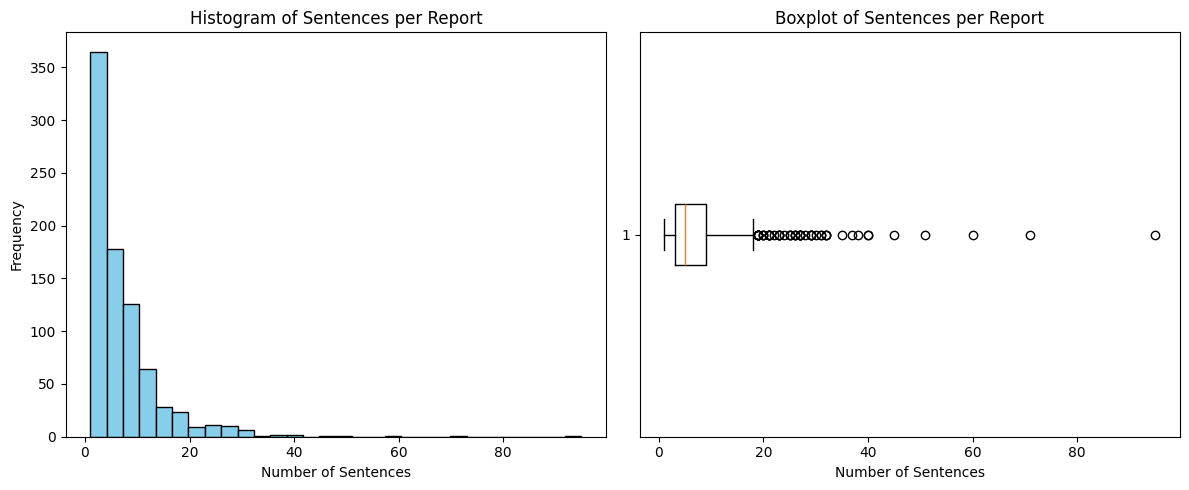

In [ ]:
import matplotlib.pyplot as plt

# Calculate stats for the distribution of sentences per report
sentences_array = np.array(sentences_per_report)
mean_sentences = np.mean(sentences_array)
median_sentences = np.median(sentences_array)
std_sentences = np.std(sentences_array)
min_sentences = np.min(sentences_array)
max_sentences = np.max(sentences_array)

print(f"Mean sentences per report: {mean_sentences:.2f}")
print(f"Median sentences per report: {median_sentences}")
print(f"Standard deviation: {std_sentences:.2f}")
print(f"Minimum sentences in a report: {min_sentences}")
print(f"Maximum sentences in a report: {max_sentences}")


# Plot histogram
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(sentences_array, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Sentences per Report')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')

# Plot boxplot
plt.subplot(1, 2, 2)
plt.boxplot(sentences_array, vert=False)
plt.title('Boxplot of Sentences per Report')
plt.xlabel('Number of Sentences')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate outlier thresholds using IQR method
Q1 = np.percentile(sentences_array, 25)
Q3 = np.percentile(sentences_array, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find indices of outlier reports
outlier_indices = np.where((sentences_array < lower_bound) | (sentences_array > upper_bound))[0]

# Print number of outlier reports
print(f"Number of outlier reports (by sentence count): {len(outlier_indices)}")

# Print content of outlier reports
for idx in outlier_indices:
    print(f"\nReport index: {idx}, Sentence count: {sentences_array[idx]}")
    print("Sentences:")
    for sent in reports_sentences[idx]:
        print(f"- {sent}")

Number of outlier reports (by sentence count): 55

Report index: 1, Sentence count: 23
Sentences:
- My first experience that would fit your description of "consciousness of consciousness" occurred at a very young age.
- Due to the death of my mother (when I was seven years old), I, as a primary school student, spent long afternoons and weekends with thoughts and questions about the meaning of life.
- One day, the following question arose in my mind: "Who actually asked that?
- Who is thinking here?
- Who am I?"
- At that moment, I felt for the first time that I am not my thoughts, but the invisible thinker.
- I felt like a lonely spectator in an empty cinema who suddenly realized that he is not the main actor in the film he is watching.
- At 16, I came into contact with Zen.
- Initially skeptical, I declared that I had no interest in meditation.
- Nevertheless, my teacher persuaded me to try it at least once.
- This led to 35 years of practice.
- My first experience was that I not only